### Import modules

In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
from spks.event_aligned import population_peth
from chiCa.chiCa.visualization_utils import separate_axes
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

pd.set_option('display.max_columns', 100)

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [31]:
save_dir = Path('processed_data')
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = save_dir / animal / session
trial_ts = pd.read_pickle(data_dir / 'trial_ts.pkl')
spike_times_per_unit = np.load(data_dir / 'spike_times_per_unit.npy', allow_pickle=True)

In [32]:
def get_balanced_trials(trial_ts, require_both_stim_types=True):
    """Get balanced trials across conditions.
    
    Takes a DataFrame of trial data and returns a balanced subset with equal numbers
    of trials across conditions (left/right category x left/right response).
    
    Args:
        trial_ts (pd.DataFrame): DataFrame containing trial data with columns:
            - trial_outcome: -1 (early withdrawal), 0 (incorrect) or 1 (correct)
            - trial_rate: Number of stimuli in trial (used to determine category)
            - category: 'left' (<12 Hz) or 'right' (>12 Hz)
            - response_side: 0 (left) or 1 (right)
            - movement_stims: array of movement stimulus timestamps 
            - stationary_stims: array of stationary stimulus timestamps
        require_both_stim_types (bool): If True, only include trials with both
            movement and stationary stimuli. Defaults to True.
            
    Returns:
        pd.DataFrame: Balanced subset of trials with equal numbers across all
            conditions (left/right category x left/right response)
        int: Number of trials per condition
            
    Notes:
        - Excludes trials with trial_rate=12 Hz (category boundary)
        - Excludes early withdrawals (trial_outcome=-1)
        - Uses random_state=42 for reproducible sampling
    """
    # Get valid trials (exclude outcome -1 and trial_rate 12)
    valid_trials = trial_ts[
        (trial_ts.trial_outcome.isin([0,1])) & 
        (trial_ts.trial_rate != 12)
    ]
    
    # Optionally require both stim types
    if require_both_stim_types:
        valid_trials = valid_trials[
            (valid_trials.movement_stims.apply(len) > 0) & 
            (valid_trials.stationary_stims.apply(len) > 0)
        ]
    
    # Find minimum number of trials across all conditions
    min_trials = min([
        len(valid_trials[(valid_trials.category == category) &
                        (valid_trials.response_side == side)])
        for category in ['left', 'right']
        for side in [0, 1]
    ])
    
    # Sample equal numbers from each condition
    balanced_trials = pd.concat([
        valid_trials[
            (valid_trials.category == category) & 
            (valid_trials.response_side == side)
        ].sample(n=min_trials, random_state=42)
        for category in ['left', 'right']
        for side in [0, 1]
    ])
    
    return balanced_trials, min_trials

balanced_trials, min_trials = get_balanced_trials(trial_ts)

In [33]:
import xarray as xr

def get_decoder_matrix(spike_times_per_unit, balanced_trials, bin_size=0.01):
    """Create binned spike rates from first stimulus to 0.1s after last stimulus."""
    n_trials = len(balanced_trials)
    n_units = len(spike_times_per_unit)
    
    # For each trial, get duration from first stim to 0.1s after last stim
    def get_stim_window(trial):
        all_stims = trial.stim_ts
        return all_stims[0], all_stims[-1] + 0.1  # first stim to 0.1s after last stim
    
    # Get start and end times for each trial
    trial_windows = balanced_trials.apply(get_stim_window, axis=1)
    trial_starts = np.array([start for start, _ in trial_windows])
    trial_ends = np.array([end for _, end in trial_windows])
    durations = trial_ends - trial_starts
    max_duration = durations.max()
    
    # Create time bins
    timebin_edges = np.arange(0, max_duration + bin_size, bin_size)
    
    # Initialize array to store binned rates with NaN
    binned_rates = np.full((n_trials, len(timebin_edges)-1, n_units), np.nan)
    
    # For each trial
    for trial_idx, (trial, (trial_start, trial_end)) in enumerate(zip(balanced_trials.itertuples(), trial_windows)):
        trial_duration = trial_end - trial_start
        n_bins = int(np.ceil(trial_duration / bin_size))
        
        # For each unit
        for unit_idx, spks in enumerate(spike_times_per_unit):
            # Get spikes in trial window
            mask = (spks >= trial_start) & (spks < trial_end)
            trial_spikes = spks[mask] - trial_start
            
            # Bin spikes and convert to rate
            counts, _ = np.histogram(trial_spikes, bins=timebin_edges[:n_bins+1])
            binned_rates[trial_idx, :n_bins, unit_idx] = counts / bin_size
    
    # Create xarray DataArray with metadata
    da = xr.DataArray(
        binned_rates,
        dims=['trial', 'time', 'unit'],
        coords={
            'trial': balanced_trials.index,
            'time': timebin_edges[:-1],
            'unit': np.arange(n_units),
            'trial_outcome': ('trial', balanced_trials.trial_outcome.values),
            'response_side': ('trial', balanced_trials.response_side.values),
            'trial_rate': ('trial', balanced_trials.trial_rate.values),
            'category': ('trial', balanced_trials.category.values),
            'detected_events': ('trial', balanced_trials.detected_events.values)
        },
        attrs={
            'bin_size': bin_size,
            'units': 'spikes/second'
        }
    )
    
    return da

decoder_matrix = get_decoder_matrix(spike_times_per_unit, balanced_trials, bin_size=0.01)

In [39]:
print("Decoder matrix shape:", decoder_matrix.shape)
print("Time range:", decoder_matrix.time.values.min(), "to", decoder_matrix.time.values.max())
print("Number of valid timepoints:", np.sum(~np.isnan(decoder_matrix).any(axis=(0,2))))

Decoder matrix shape: (96, 107, 178)
Time range: 0.0 to 1.06
Number of valid timepoints: <xarray.DataArray ()> Size: 8B
array(66)


Number of time windows analyzed: 14
Start times used: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65]


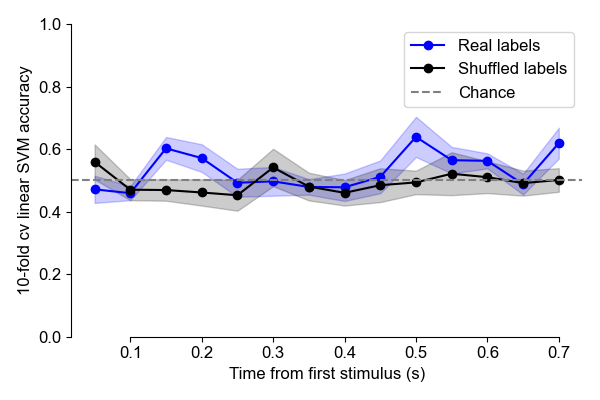

In [67]:
from sklearn.svm import SVC
# Define time windows to analyze (sliding windows)
window_size = 0.1  # 100ms windows
step_size = 0.05   # 50ms steps
start_times = np.arange(0, 1.5, step_size)  # Adjust range as needed

# Initialize arrays to store results for each time window
time_accuracies = []
time_accuracies_sem = []  # Changed to SEM
shuffle_accuracies = []  # Add array for shuffle accuracies
shuffle_accuracies_sem = []  # Add array for shuffle SEM

# For each time window
for start_time in start_times:
    # Get neural activity during this window
    stim_window = decoder_matrix.sel(time=slice(start_time, start_time + window_size))
    
    # Average activity across time bins to get one value per unit per trial
    X = stim_window.mean(dim='time').values
    y = (decoder_matrix.category == 'right').values.astype(int)
    
    # Skip windows with NaN values
    if np.isnan(X).any():
        continue
    
    # Initialize arrays for this time window
    window_accuracies = []
    window_shuffle_accuracies = []  # Add array for shuffle accuracies in this window
    
    # Cross validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create shuffled labels for training
        rng = np.random.Generator(np.random.PCG64())
        y_train_shuffled = rng.permutation(y_train)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        C = 1
        # Train SVM on real labels
        svm = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm.fit(X_train_scaled, y_train)
        
        # Make predictions with real labels
        y_pred = svm.predict(X_test_scaled)
        window_accuracies.append(accuracy_score(y_test, y_pred))
        
        # Train SVM on shuffled labels
        svm_shuffled = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm_shuffled.fit(X_train_scaled, y_train_shuffled)
        
        # Make predictions with shuffled labels
        y_pred_shuffled = svm_shuffled.predict(X_test_scaled)
        window_shuffle_accuracies.append(accuracy_score(y_test, y_pred_shuffled))
    
    # Store mean and SEM of accuracies for this time window
    time_accuracies.append(np.mean(window_accuracies))
    time_accuracies_sem.append(np.std(window_accuracies) / np.sqrt(len(window_accuracies)))
    shuffle_accuracies.append(np.mean(window_shuffle_accuracies))
    shuffle_accuracies_sem.append(np.std(window_shuffle_accuracies) / np.sqrt(len(window_shuffle_accuracies)))
    
# Convert to numpy arrays for plotting
valid_times = start_times[:len(time_accuracies)] + window_size/2
time_accuracies = np.array(time_accuracies)
time_accuracies_sem = np.array(time_accuracies_sem)
shuffle_accuracies = np.array(shuffle_accuracies)
shuffle_accuracies_sem = np.array(shuffle_accuracies_sem)

# After the decoding loop, add these diagnostic prints
print("Number of time windows analyzed:", len(time_accuracies))
print("Start times used:", start_times[:len(time_accuracies)])

# Modified plotting code
plt.figure(figsize=(6, 4))
plt.plot(valid_times, time_accuracies, '-bo', label='Real labels')
plt.fill_between(valid_times, 
                 time_accuracies - time_accuracies_sem,
                 time_accuracies + time_accuracies_sem,
                 alpha=0.2, color='b')
plt.plot(valid_times, shuffle_accuracies, '-ko', label='Shuffled labels')
plt.fill_between(valid_times,
                 shuffle_accuracies - shuffle_accuracies_sem,
                 shuffle_accuracies + shuffle_accuracies_sem,
                 alpha=0.2, color='k')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Chance')
plt.xlabel('Time from first stimulus (s)')
plt.ylabel('10-fold cv linear SVM accuracy')
plt.ylim(0, 1)
# plt.title('stimulus category decoding')
plt.legend()
separate_axes(plt.gca())
plt.tight_layout()
plt.show()
plt.savefig('/Users/gabriel/lib/oqe-figures/decoding/stim_category_decoding.svg', format='svg', dpi=300)

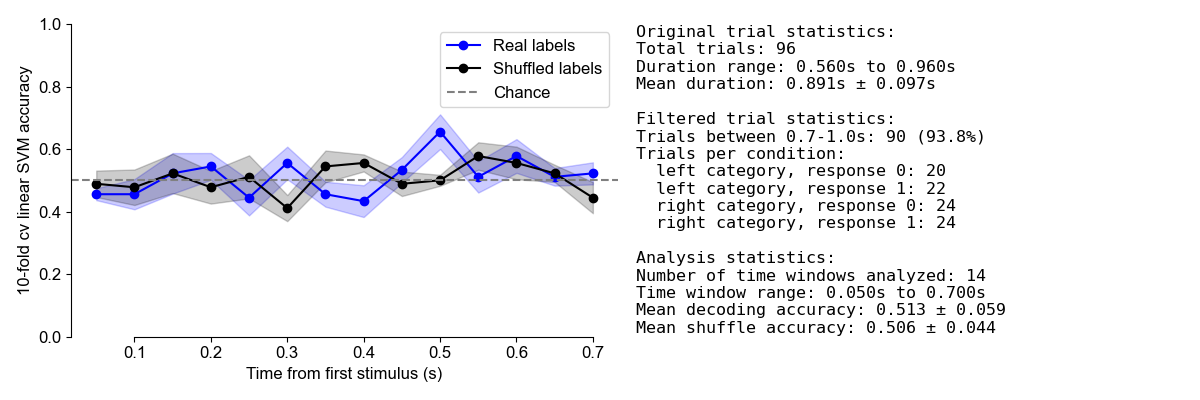

In [78]:
def get_trial_duration(stim_ts):
    return stim_ts[-1] - stim_ts[0]

trial_durations = balanced_trials.stim_ts.apply(get_trial_duration)

# Get trial statistics
stats_text = "Original trial statistics:\n"
stats_text += f"Total trials: {len(trial_durations)}\n"
stats_text += f"Duration range: {trial_durations.min():.3f}s to {trial_durations.max():.3f}s\n"
stats_text += f"Mean duration: {trial_durations.mean():.3f}s ± {trial_durations.std():.3f}s\n\n"

# Filter trials to only include those between 0.9 and 1 second
duration_mask = (trial_durations >= 0.7) & (trial_durations <= 1.0)
filtered_trials = balanced_trials[duration_mask]
filtered_decoder_matrix = decoder_matrix.sel(trial=filtered_trials.index)

# Add filtered trial statistics
stats_text += f"Filtered trial statistics:\n"
stats_text += f"Trials between 0.7-1.0s: {len(filtered_trials)} ({len(filtered_trials)/len(trial_durations)*100:.1f}%)\n"
stats_text += f"Trials per condition:\n"
for category in ['left', 'right']:
    for response in [0, 1]:
        n_trials = len(filtered_trials[
            (filtered_trials.category == category) & 
            (filtered_trials.response_side == response)
        ])
        stats_text += f"  {category} category, response {response}: {n_trials}\n"

# Define time windows to analyze (sliding windows)
window_size = 0.1  # 100ms windows
step_size = 0.05   # 50ms steps
start_times = np.arange(0, 0.7, step_size)  # Now we can safely go up to 0.9s

# Initialize arrays to store results
time_accuracies = []
time_accuracies_sem = []
shuffle_accuracies = []
shuffle_accuracies_sem = []

# For each time window
for start_time in start_times:
    # Get neural activity during this window
    stim_window = filtered_decoder_matrix.sel(time=slice(start_time, start_time + window_size))
    
    # Average activity across time bins to get one value per unit per trial
    X = stim_window.mean(dim='time').values
    y = (filtered_decoder_matrix.category == 'right').values.astype(int)
    
    # Skip windows with NaN values
    if np.isnan(X).any():
        print(f"Skipping window at {start_time}s due to NaN values")
        continue
    
    # Initialize arrays for this time window
    window_accuracies = []
    window_shuffle_accuracies = []
    
    # Cross validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create shuffled labels for training
        rng = np.random.Generator(np.random.PCG64())
        y_train_shuffled = rng.permutation(y_train)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        C = 1
        # Train SVM on real labels
        svm = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm.fit(X_train_scaled, y_train)
        
        # Make predictions with real labels
        y_pred = svm.predict(X_test_scaled)
        window_accuracies.append(accuracy_score(y_test, y_pred))
        
        # Train SVM on shuffled labels
        svm_shuffled = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm_shuffled.fit(X_train_scaled, y_train_shuffled)
        
        # Make predictions with shuffled labels
        y_pred_shuffled = svm_shuffled.predict(X_test_scaled)
        window_shuffle_accuracies.append(accuracy_score(y_test, y_pred_shuffled))
    
    # Store mean and SEM of accuracies for this time window
    time_accuracies.append(np.mean(window_accuracies))
    time_accuracies_sem.append(np.std(window_accuracies) / np.sqrt(len(window_accuracies)))
    shuffle_accuracies.append(np.mean(window_shuffle_accuracies))
    shuffle_accuracies_sem.append(np.std(window_shuffle_accuracies) / np.sqrt(len(window_shuffle_accuracies)))

# Convert to numpy arrays for plotting
valid_times = start_times[:len(time_accuracies)] + window_size/2
time_accuracies = np.array(time_accuracies)
time_accuracies_sem = np.array(time_accuracies_sem)
shuffle_accuracies = np.array(shuffle_accuracies)
shuffle_accuracies_sem = np.array(shuffle_accuracies_sem)

# Add final analysis statistics
stats_text += f"\nAnalysis statistics:\n"
stats_text += f"Number of time windows analyzed: {len(time_accuracies)}\n"
stats_text += f"Time window range: {valid_times[0]:.3f}s to {valid_times[-1]:.3f}s\n"
stats_text += f"Mean decoding accuracy: {time_accuracies.mean():.3f} ± {time_accuracies.std():.3f}\n"
stats_text += f"Mean shuffle accuracy: {shuffle_accuracies.mean():.3f} ± {shuffle_accuracies.std():.3f}"

# Create figure with two subplots side by side
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)  # Left subplot for the plot
ax2 = plt.subplot(122)  # Right subplot for the text

# Plot in the left subplot
ax1.plot(valid_times, time_accuracies, '-bo', label='Real labels')
ax1.fill_between(valid_times, 
                time_accuracies - time_accuracies_sem,
                time_accuracies + time_accuracies_sem,
                alpha=0.2, color='b')
ax1.plot(valid_times, shuffle_accuracies, '-ko', label='Shuffled labels')
ax1.fill_between(valid_times,
                shuffle_accuracies - shuffle_accuracies_sem,
                shuffle_accuracies + shuffle_accuracies_sem,
                alpha=0.2, color='k')
ax1.axhline(y=0.5, color='gray', linestyle='--', label='Chance')
ax1.set_xlabel('Time from first stimulus (s)')
ax1.set_ylabel('10-fold cv linear SVM accuracy')
ax1.set_ylim(0, 1)
ax1.legend()
separate_axes(ax1)

# Add text in the right subplot
ax2.text(0, 0.5, stats_text, va='center', family='monospace')
ax2.axis('off')  # Hide axes for text subplot

plt.tight_layout()
plt.show()
plt.savefig('/Users/gabriel/lib/oqe-figures/decoding/stim_category_decoding.svg', format='svg', dpi=300)

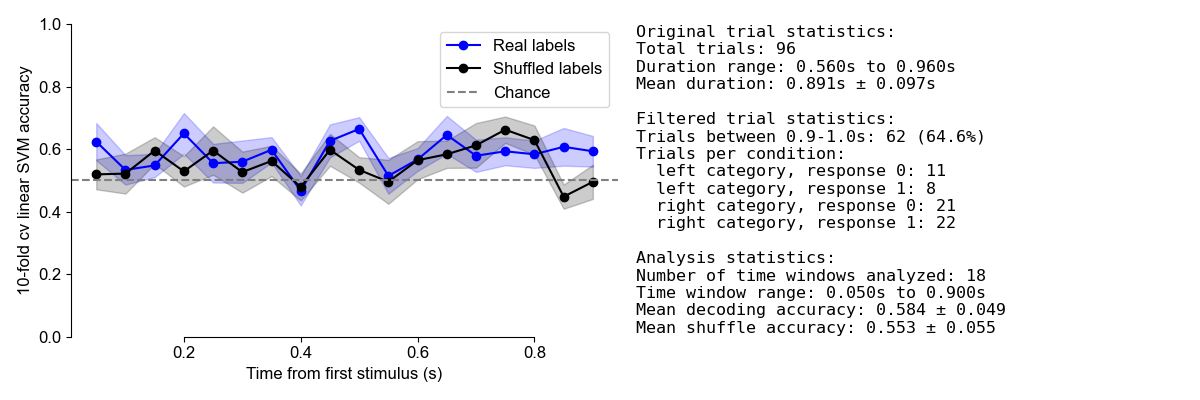

In [90]:
def get_trial_duration(stim_ts):
    return stim_ts[-1] - stim_ts[0]

trial_durations = balanced_trials.stim_ts.apply(get_trial_duration)

# Get trial statistics
stats_text = "Original trial statistics:\n"
stats_text += f"Total trials: {len(trial_durations)}\n"
stats_text += f"Duration range: {trial_durations.min():.3f}s to {trial_durations.max():.3f}s\n"
stats_text += f"Mean duration: {trial_durations.mean():.3f}s ± {trial_durations.std():.3f}s\n\n"

# Filter trials to only include those between 0.9 and 1 second
duration_mask = (trial_durations >= 0.9) & (trial_durations <= 1.0)
filtered_trials = balanced_trials[duration_mask]
filtered_decoder_matrix = decoder_matrix.sel(trial=filtered_trials.index)

# Add filtered trial statistics
stats_text += f"Filtered trial statistics:\n"
stats_text += f"Trials between 0.9-1.0s: {len(filtered_trials)} ({len(filtered_trials)/len(trial_durations)*100:.1f}%)\n"
stats_text += f"Trials per condition:\n"
for category in ['left', 'right']:
    for response in [0, 1]:
        n_trials = len(filtered_trials[
            (filtered_trials.category == category) & 
            (filtered_trials.response_side == response)
        ])
        stats_text += f"  {category} category, response {response}: {n_trials}\n"

# Define time windows to analyze (sliding windows)
window_size = 0.1  # 100ms windows
step_size = 0.05   # 50ms steps
start_times = np.arange(0, 0.9, step_size)  # Now we can safely go up to 0.9s

# Initialize arrays to store results
time_accuracies = []
time_accuracies_sem = []
shuffle_accuracies = []
shuffle_accuracies_sem = []

# For each time window
for start_time in start_times:
    # Get neural activity during this window
    stim_window = filtered_decoder_matrix.sel(time=slice(start_time, start_time + window_size))
    
    # Average activity across time bins to get one value per unit per trial
    X = stim_window.mean(dim='time').values
    y = (filtered_decoder_matrix.category == 'right').values.astype(int)
    
    # Skip windows with NaN values
    if np.isnan(X).any():
        print(f"Skipping window at {start_time}s due to NaN values")
        continue
    
    # Initialize arrays for this time window
    window_accuracies = []
    window_shuffle_accuracies = []
    
    # Cross validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create shuffled labels for training
        rng = np.random.Generator(np.random.PCG64())
        y_train_shuffled = rng.permutation(y_train)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        C = 1
        # Train SVM on real labels
        svm = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm.fit(X_train_scaled, y_train)
        
        # Make predictions with real labels
        y_pred = svm.predict(X_test_scaled)
        window_accuracies.append(accuracy_score(y_test, y_pred))
        
        # Train SVM on shuffled labels
        svm_shuffled = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm_shuffled.fit(X_train_scaled, y_train_shuffled)
        
        # Make predictions with shuffled labels
        y_pred_shuffled = svm_shuffled.predict(X_test_scaled)
        window_shuffle_accuracies.append(accuracy_score(y_test, y_pred_shuffled))
    
    # Store mean and SEM of accuracies for this time window
    time_accuracies.append(np.mean(window_accuracies))
    time_accuracies_sem.append(np.std(window_accuracies) / np.sqrt(len(window_accuracies)))
    shuffle_accuracies.append(np.mean(window_shuffle_accuracies))
    shuffle_accuracies_sem.append(np.std(window_shuffle_accuracies) / np.sqrt(len(window_shuffle_accuracies)))

# Convert to numpy arrays for plotting
valid_times = start_times[:len(time_accuracies)] + window_size/2
time_accuracies = np.array(time_accuracies)
time_accuracies_sem = np.array(time_accuracies_sem)
shuffle_accuracies = np.array(shuffle_accuracies)
shuffle_accuracies_sem = np.array(shuffle_accuracies_sem)

# Add final analysis statistics
stats_text += f"\nAnalysis statistics:\n"
stats_text += f"Number of time windows analyzed: {len(time_accuracies)}\n"
stats_text += f"Time window range: {valid_times[0]:.3f}s to {valid_times[-1]:.3f}s\n"
stats_text += f"Mean decoding accuracy: {time_accuracies.mean():.3f} ± {time_accuracies.std():.3f}\n"
stats_text += f"Mean shuffle accuracy: {shuffle_accuracies.mean():.3f} ± {shuffle_accuracies.std():.3f}"

# Create figure with two subplots side by side
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)  # Left subplot for the plot
ax2 = plt.subplot(122)  # Right subplot for the text

# Plot in the left subplot
ax1.plot(valid_times, time_accuracies, '-bo', label='Real labels')
ax1.fill_between(valid_times, 
                time_accuracies - time_accuracies_sem,
                time_accuracies + time_accuracies_sem,
                alpha=0.2, color='b')
ax1.plot(valid_times, shuffle_accuracies, '-ko', label='Shuffled labels')
ax1.fill_between(valid_times,
                shuffle_accuracies - shuffle_accuracies_sem,
                shuffle_accuracies + shuffle_accuracies_sem,
                alpha=0.2, color='k')
ax1.axhline(y=0.5, color='gray', linestyle='--', label='Chance')
ax1.set_xlabel('Time from first stimulus (s)')
ax1.set_ylabel('10-fold cv linear SVM accuracy')
ax1.set_ylim(0, 1)
ax1.legend()
separate_axes(ax1)

# Add text in the right subplot
ax2.text(0, 0.5, stats_text, va='center', family='monospace')
ax2.axis('off')  # Hide axes for text subplot

plt.tight_layout()
plt.show()
plt.savefig('/Users/gabriel/lib/oqe-figures/decoding/stim_category_decoding_0.9-1.0s.svg', format='svg', dpi=300)

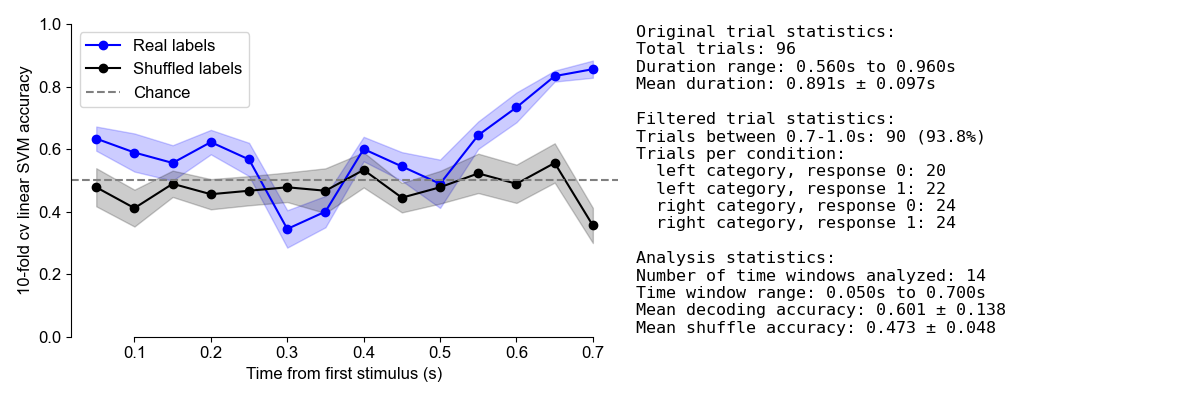

In [73]:
def get_trial_duration(stim_ts):
    return stim_ts[-1] - stim_ts[0]

trial_durations = balanced_trials.stim_ts.apply(get_trial_duration)

# Get trial statistics
stats_text = "Original trial statistics:\n"
stats_text += f"Total trials: {len(trial_durations)}\n"
stats_text += f"Duration range: {trial_durations.min():.3f}s to {trial_durations.max():.3f}s\n"
stats_text += f"Mean duration: {trial_durations.mean():.3f}s ± {trial_durations.std():.3f}s\n\n"

# Filter trials to only include those between 0.9 and 1 second
duration_mask = (trial_durations >= 0.7) & (trial_durations <= 1.0)
filtered_trials = balanced_trials[duration_mask]
filtered_decoder_matrix = decoder_matrix.sel(trial=filtered_trials.index)

# Add filtered trial statistics
stats_text += f"Filtered trial statistics:\n"
stats_text += f"Trials between 0.7-1.0s: {len(filtered_trials)} ({len(filtered_trials)/len(trial_durations)*100:.1f}%)\n"
stats_text += f"Trials per condition:\n"
for category in ['left', 'right']:
    for response in [0, 1]:
        n_trials = len(filtered_trials[
            (filtered_trials.category == category) & 
            (filtered_trials.response_side == response)
        ])
        stats_text += f"  {category} category, response {response}: {n_trials}\n"

# Define time windows to analyze (sliding windows)
window_size = 0.1  # 100ms windows
step_size = 0.05   # 50ms steps
start_times = np.arange(0, 0.7, step_size)  # Now we can safely go up to 0.9s

# Initialize arrays to store results
time_accuracies = []
time_accuracies_sem = []
shuffle_accuracies = []
shuffle_accuracies_sem = []

# For each time window
for start_time in start_times:
    # Get neural activity during this window
    stim_window = filtered_decoder_matrix.sel(time=slice(start_time, start_time + window_size))
    
    # Average activity across time bins to get one value per unit per trial
    X = stim_window.mean(dim='time').values
    y = (filtered_decoder_matrix.response_side == 1).values.astype(int)
    
    # Skip windows with NaN values
    if np.isnan(X).any():
        print(f"Skipping window at {start_time}s due to NaN values")
        continue
    
    # Initialize arrays for this time window
    window_accuracies = []
    window_shuffle_accuracies = []
    
    # Cross validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create shuffled labels for training
        rng = np.random.Generator(np.random.PCG64())
        y_train_shuffled = rng.permutation(y_train)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        C = 1
        # Train SVM on real labels
        svm = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm.fit(X_train_scaled, y_train)
        
        # Make predictions with real labels
        y_pred = svm.predict(X_test_scaled)
        window_accuracies.append(accuracy_score(y_test, y_pred))
        
        # Train SVM on shuffled labels
        svm_shuffled = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm_shuffled.fit(X_train_scaled, y_train_shuffled)
        
        # Make predictions with shuffled labels
        y_pred_shuffled = svm_shuffled.predict(X_test_scaled)
        window_shuffle_accuracies.append(accuracy_score(y_test, y_pred_shuffled))
    
    # Store mean and SEM of accuracies for this time window
    time_accuracies.append(np.mean(window_accuracies))
    time_accuracies_sem.append(np.std(window_accuracies) / np.sqrt(len(window_accuracies)))
    shuffle_accuracies.append(np.mean(window_shuffle_accuracies))
    shuffle_accuracies_sem.append(np.std(window_shuffle_accuracies) / np.sqrt(len(window_shuffle_accuracies)))

# Convert to numpy arrays for plotting
valid_times = start_times[:len(time_accuracies)] + window_size/2
time_accuracies = np.array(time_accuracies)
time_accuracies_sem = np.array(time_accuracies_sem)
shuffle_accuracies = np.array(shuffle_accuracies)
shuffle_accuracies_sem = np.array(shuffle_accuracies_sem)

# Add final analysis statistics
stats_text += f"\nAnalysis statistics:\n"
stats_text += f"Number of time windows analyzed: {len(time_accuracies)}\n"
stats_text += f"Time window range: {valid_times[0]:.3f}s to {valid_times[-1]:.3f}s\n"
stats_text += f"Mean decoding accuracy: {time_accuracies.mean():.3f} ± {time_accuracies.std():.3f}\n"
stats_text += f"Mean shuffle accuracy: {shuffle_accuracies.mean():.3f} ± {shuffle_accuracies.std():.3f}"

# Create figure with two subplots side by side
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)  # Left subplot for the plot
ax2 = plt.subplot(122)  # Right subplot for the text

# Plot in the left subplot
ax1.plot(valid_times, time_accuracies, '-bo', label='Real labels')
ax1.fill_between(valid_times, 
                time_accuracies - time_accuracies_sem,
                time_accuracies + time_accuracies_sem,
                alpha=0.2, color='b')
ax1.plot(valid_times, shuffle_accuracies, '-ko', label='Shuffled labels')
ax1.fill_between(valid_times,
                shuffle_accuracies - shuffle_accuracies_sem,
                shuffle_accuracies + shuffle_accuracies_sem,
                alpha=0.2, color='k')
ax1.axhline(y=0.5, color='gray', linestyle='--', label='Chance')
ax1.set_xlabel('Time from first stimulus (s)')
ax1.set_ylabel('10-fold cv linear SVM accuracy')
ax1.set_ylim(0, 1)
ax1.legend()
separate_axes(ax1)

# Add text in the right subplot
ax2.text(0, 0.5, stats_text, va='center', family='monospace')
ax2.axis('off')  # Hide axes for text subplot

plt.tight_layout()
plt.show()
plt.savefig('/Users/gabriel/lib/oqe-figures/decoding/response_side_decoding.svg', format='svg', dpi=300)

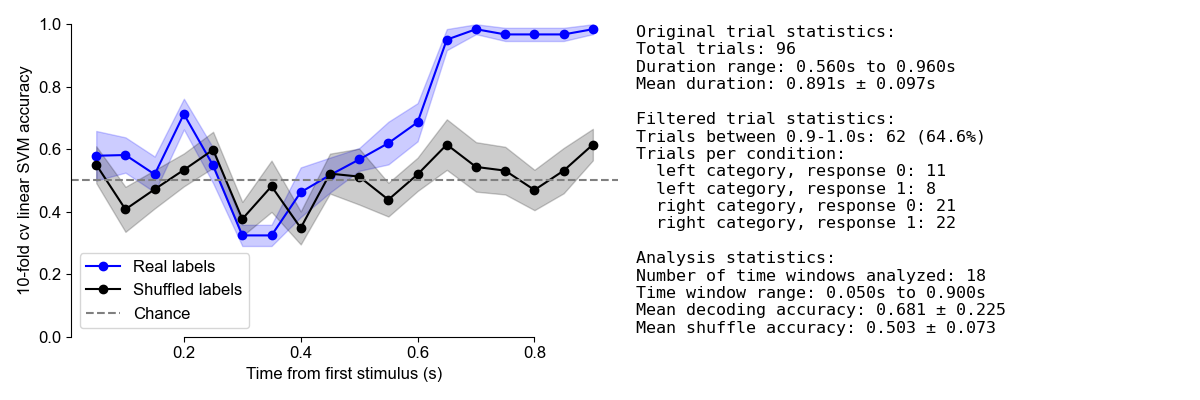

In [91]:
def get_trial_duration(stim_ts):
    return stim_ts[-1] - stim_ts[0]

trial_durations = balanced_trials.stim_ts.apply(get_trial_duration)

# Get trial statistics
stats_text = "Original trial statistics:\n"
stats_text += f"Total trials: {len(trial_durations)}\n"
stats_text += f"Duration range: {trial_durations.min():.3f}s to {trial_durations.max():.3f}s\n"
stats_text += f"Mean duration: {trial_durations.mean():.3f}s ± {trial_durations.std():.3f}s\n\n"

# Filter trials to only include those between 0.9 and 1 second
duration_mask = (trial_durations >= 0.9) & (trial_durations <= 1.0)
filtered_trials = balanced_trials[duration_mask]
filtered_decoder_matrix = decoder_matrix.sel(trial=filtered_trials.index)

# Add filtered trial statistics
stats_text += f"Filtered trial statistics:\n"
stats_text += f"Trials between 0.9-1.0s: {len(filtered_trials)} ({len(filtered_trials)/len(trial_durations)*100:.1f}%)\n"
stats_text += f"Trials per condition:\n"
for category in ['left', 'right']:
    for response in [0, 1]:
        n_trials = len(filtered_trials[
            (filtered_trials.category == category) & 
            (filtered_trials.response_side == response)
        ])
        stats_text += f"  {category} category, response {response}: {n_trials}\n"

# Define time windows to analyze (sliding windows)
window_size = 0.1  # 100ms windows
step_size = 0.05   # 50ms steps
start_times = np.arange(0, 0.9, step_size)  # Now we can safely go up to 0.9s

# Initialize arrays to store results
time_accuracies = []
time_accuracies_sem = []
shuffle_accuracies = []
shuffle_accuracies_sem = []

# For each time window
for start_time in start_times:
    # Get neural activity during this window
    stim_window = filtered_decoder_matrix.sel(time=slice(start_time, start_time + window_size))
    
    # Average activity across time bins to get one value per unit per trial
    X = stim_window.mean(dim='time').values
    y = (filtered_decoder_matrix.response_side == 1).values.astype(int)
    
    # Skip windows with NaN values
    if np.isnan(X).any():
        print(f"Skipping window at {start_time}s due to NaN values")
        continue
    
    # Initialize arrays for this time window
    window_accuracies = []
    window_shuffle_accuracies = []
    
    # Cross validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create shuffled labels for training
        rng = np.random.Generator(np.random.PCG64())
        y_train_shuffled = rng.permutation(y_train)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        C = 1
        # Train SVM on real labels
        svm = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm.fit(X_train_scaled, y_train)
        
        # Make predictions with real labels
        y_pred = svm.predict(X_test_scaled)
        window_accuracies.append(accuracy_score(y_test, y_pred))
        
        # Train SVM on shuffled labels
        svm_shuffled = LinearSVC(C=C, penalty='l2', random_state=42, dual='auto')
        svm_shuffled.fit(X_train_scaled, y_train_shuffled)
        
        # Make predictions with shuffled labels
        y_pred_shuffled = svm_shuffled.predict(X_test_scaled)
        window_shuffle_accuracies.append(accuracy_score(y_test, y_pred_shuffled))
    
    # Store mean and SEM of accuracies for this time window
    time_accuracies.append(np.mean(window_accuracies))
    time_accuracies_sem.append(np.std(window_accuracies) / np.sqrt(len(window_accuracies)))
    shuffle_accuracies.append(np.mean(window_shuffle_accuracies))
    shuffle_accuracies_sem.append(np.std(window_shuffle_accuracies) / np.sqrt(len(window_shuffle_accuracies)))

# Convert to numpy arrays for plotting
valid_times = start_times[:len(time_accuracies)] + window_size/2
time_accuracies = np.array(time_accuracies)
time_accuracies_sem = np.array(time_accuracies_sem)
shuffle_accuracies = np.array(shuffle_accuracies)
shuffle_accuracies_sem = np.array(shuffle_accuracies_sem)

# Add final analysis statistics
stats_text += f"\nAnalysis statistics:\n"
stats_text += f"Number of time windows analyzed: {len(time_accuracies)}\n"
stats_text += f"Time window range: {valid_times[0]:.3f}s to {valid_times[-1]:.3f}s\n"
stats_text += f"Mean decoding accuracy: {time_accuracies.mean():.3f} ± {time_accuracies.std():.3f}\n"
stats_text += f"Mean shuffle accuracy: {shuffle_accuracies.mean():.3f} ± {shuffle_accuracies.std():.3f}"

# Create figure with two subplots side by side
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)  # Left subplot for the plot
ax2 = plt.subplot(122)  # Right subplot for the text

# Plot in the left subplot
ax1.plot(valid_times, time_accuracies, '-bo', label='Real labels')
ax1.fill_between(valid_times, 
                time_accuracies - time_accuracies_sem,
                time_accuracies + time_accuracies_sem,
                alpha=0.2, color='b')
ax1.plot(valid_times, shuffle_accuracies, '-ko', label='Shuffled labels')
ax1.fill_between(valid_times,
                shuffle_accuracies - shuffle_accuracies_sem,
                shuffle_accuracies + shuffle_accuracies_sem,
                alpha=0.2, color='k')
ax1.axhline(y=0.5, color='gray', linestyle='--', label='Chance')
ax1.set_xlabel('Time from first stimulus (s)')
ax1.set_ylabel('10-fold cv linear SVM accuracy')
ax1.set_ylim(0, 1)
ax1.legend()
separate_axes(ax1)

# Add text in the right subplot
ax2.text(0, 0.5, stats_text, va='center', family='monospace')
ax2.axis('off')  # Hide axes for text subplot

plt.tight_layout()
plt.show()
plt.savefig('/Users/gabriel/lib/oqe-figures/decoding/response_side_decoding_0.9-1.0s.svg', format='svg', dpi=300)

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay


def plot_training_data_with_decision_boundary(
    kernel, ax=None, long_title=True, support_vectors=True
):
    # Train the SVC
    clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

    # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    if support_vectors:
        # Plot bigger circles around samples that serve as support vectors
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=150,
            facecolors="none",
            edgecolors="k",
        )

    # Plot samples by color and add legend
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    if long_title:
        ax.set_title(f" Decision boundaries of {kernel} kernel in SVC")
    else:
        ax.set_title(kernel)

    if ax is None:
        plt.show()

### PCA

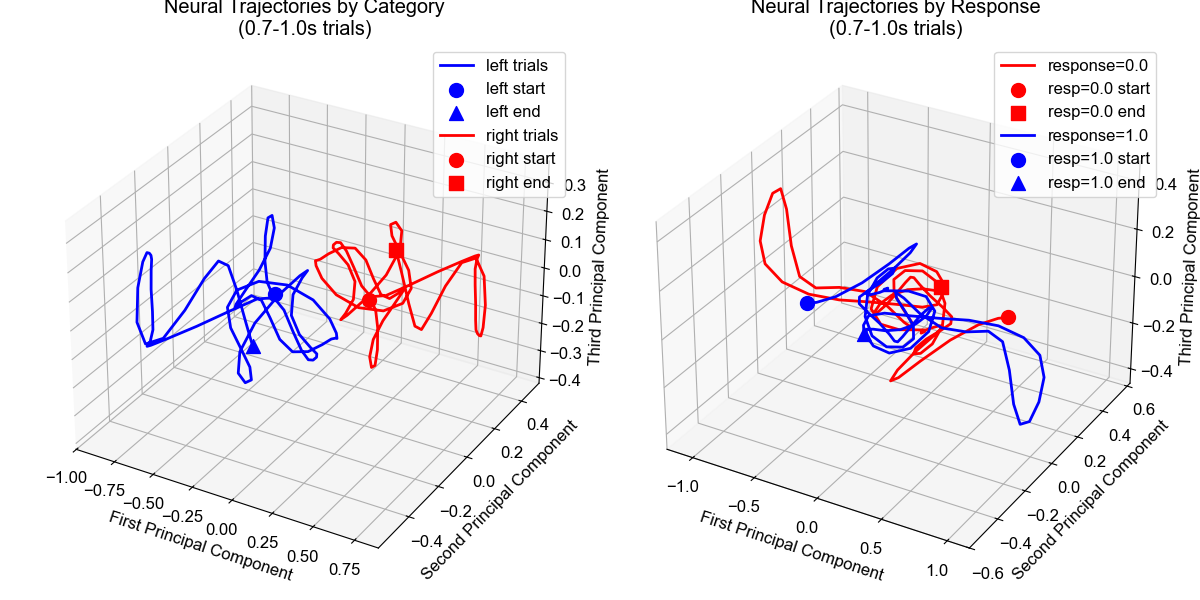

In [100]:
def get_trial_duration(stim_ts):
    return stim_ts[-1] - stim_ts[0]

trial_durations = balanced_trials.stim_ts.apply(get_trial_duration)

# Get trial statistics
stats_text = "Original trial statistics:\n"
stats_text += f"Total trials: {len(trial_durations)}\n"
stats_text += f"Duration range: {trial_durations.min():.3f}s to {trial_durations.max():.3f}s\n"
stats_text += f"Mean duration: {trial_durations.mean():.3f}s ± {trial_durations.std():.3f}s\n\n"

# Filter trials to only include those between 0.9 and 1 second
duration_mask = (trial_durations >= 0.7) & (trial_durations <= 1.0)
filtered_trials = balanced_trials[duration_mask]
filtered_decoder_matrix = decoder_matrix.sel(trial=filtered_trials.index)

# Add filtered trial statistics
stats_text += f"Filtered trial statistics:\n"
stats_text += f"Trials between 0.7-1.0s: {len(filtered_trials)} ({len(filtered_trials)/len(trial_durations)*100:.1f}%)\n"
stats_text += f"Trials per condition:\n"
for category in ['left', 'right']:
    for response in [0, 1]:
        n_trials = len(filtered_trials[
            (filtered_trials.category == category) & 
            (filtered_trials.response_side == response)
        ])
        stats_text += f"  {category} category, response {response}: {n_trials}\n"

# Get full trial-by-time-by-unit data from filtered trials
X_full = filtered_decoder_matrix.values

# Remove timepoints with any NaN values
valid_timepoints = ~np.any(np.isnan(X_full), axis=(0,2))
X_full = X_full[:,valid_timepoints,:]

# Scale the full dataset with a new scaler
scaler_full = StandardScaler()
X_full_reshaped = X_full.reshape(-1, X_full.shape[-1])  # Reshape to 2D for scaling
X_full_scaled = scaler_full.fit_transform(X_full_reshaped)
X_full_scaled = X_full_scaled.reshape(X_full.shape)  # Reshape back to 3D

# Project each timepoint through PCA with 3 components
pca_3d = PCA(n_components=3)
X_full_3d = np.zeros((X_full_scaled.shape[0], X_full_scaled.shape[1], 3))
for t in range(X_full_scaled.shape[1]):
    X_full_3d[:,t,:] = pca_3d.fit_transform(X_full_scaled[:,t,:])

# Create figure with two subplots
fig = plt.figure(figsize=(12,6))

# First subplot for categories
ax1 = fig.add_subplot(121, projection='3d')

# Plot average trajectories for each category
categories = filtered_decoder_matrix.category.values
unique_categories = np.unique(categories)
colors = {'left': 'blue', 'right': 'red'}
markers = {'left': '^', 'right': 's'}

# Apply smoothing using a Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2

for cat in unique_categories:
    cat_mask = categories == cat
    mean_trajectory = X_full_3d[cat_mask,:,:].mean(axis=0)
    
    # Smooth each dimension separately
    smoothed_trajectory = np.zeros_like(mean_trajectory)
    for dim in range(3):
        smoothed_trajectory[:,dim] = gaussian_filter1d(mean_trajectory[:,dim], sigma)
    
    ax1.plot(smoothed_trajectory[:,0], smoothed_trajectory[:,1], smoothed_trajectory[:,2],
            color=colors[cat], label=f'{cat} trials',
            linewidth=2)
    
    # Plot start point (circle) and end point (category-specific marker)
    ax1.scatter(smoothed_trajectory[0,0], smoothed_trajectory[0,1], smoothed_trajectory[0,2],
              color=colors[cat], marker='o', s=100, label=f'{cat} start')
    ax1.scatter(smoothed_trajectory[-1,0], smoothed_trajectory[-1,1], smoothed_trajectory[-1,2],
              color=colors[cat], marker=markers[cat], s=100, label=f'{cat} end')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component') 
ax1.set_zlabel('Third Principal Component')
ax1.set_title('Neural Trajectories by Category\n(0.7-1.0s trials)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second subplot for response values
ax2 = fig.add_subplot(122, projection='3d')

# Plot average trajectories for each response value
response_values = filtered_decoder_matrix.response_side.values
unique_responses = np.unique(response_values)
# Map 0 to 'right' and 1 to 'left' to use same colors/markers
response_mapping = {1: 'left', 0: 'right'}

for resp in unique_responses:
    resp_mask = response_values == resp
    mean_trajectory = X_full_3d[resp_mask,:,:].mean(axis=0)
    
    # Smooth each dimension separately
    smoothed_trajectory = np.zeros_like(mean_trajectory)
    for dim in range(3):
        smoothed_trajectory[:,dim] = gaussian_filter1d(mean_trajectory[:,dim], sigma)
    
    mapped_resp = response_mapping[resp]
    ax2.plot(smoothed_trajectory[:,0], smoothed_trajectory[:,1], smoothed_trajectory[:,2],
            color=colors[mapped_resp], label=f'response={resp}',
            linewidth=2)
    
    # Plot start point (circle) and end point (response-specific marker)
    ax2.scatter(smoothed_trajectory[0,0], smoothed_trajectory[0,1], smoothed_trajectory[0,2],
              color=colors[mapped_resp], marker='o', s=100, label=f'resp={resp} start')
    ax2.scatter(smoothed_trajectory[-1,0], smoothed_trajectory[-1,1], smoothed_trajectory[-1,2],
              color=colors[mapped_resp], marker=markers[mapped_resp], s=100, label=f'resp={resp} end')

ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component') 
ax2.set_zlabel('Third Principal Component')
ax2.set_title('Neural Trajectories by Response\n(0.7-1.0s trials)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('/Users/gabriel/lib/oqe-figures/decoding/PCA_trajectories_0.7-1.0s.svg', format='svg', dpi=300)

left stim, response 0: 20 trials
left stim, response 1: 22 trials
right stim, response 0: 24 trials
right stim, response 1: 24 trials


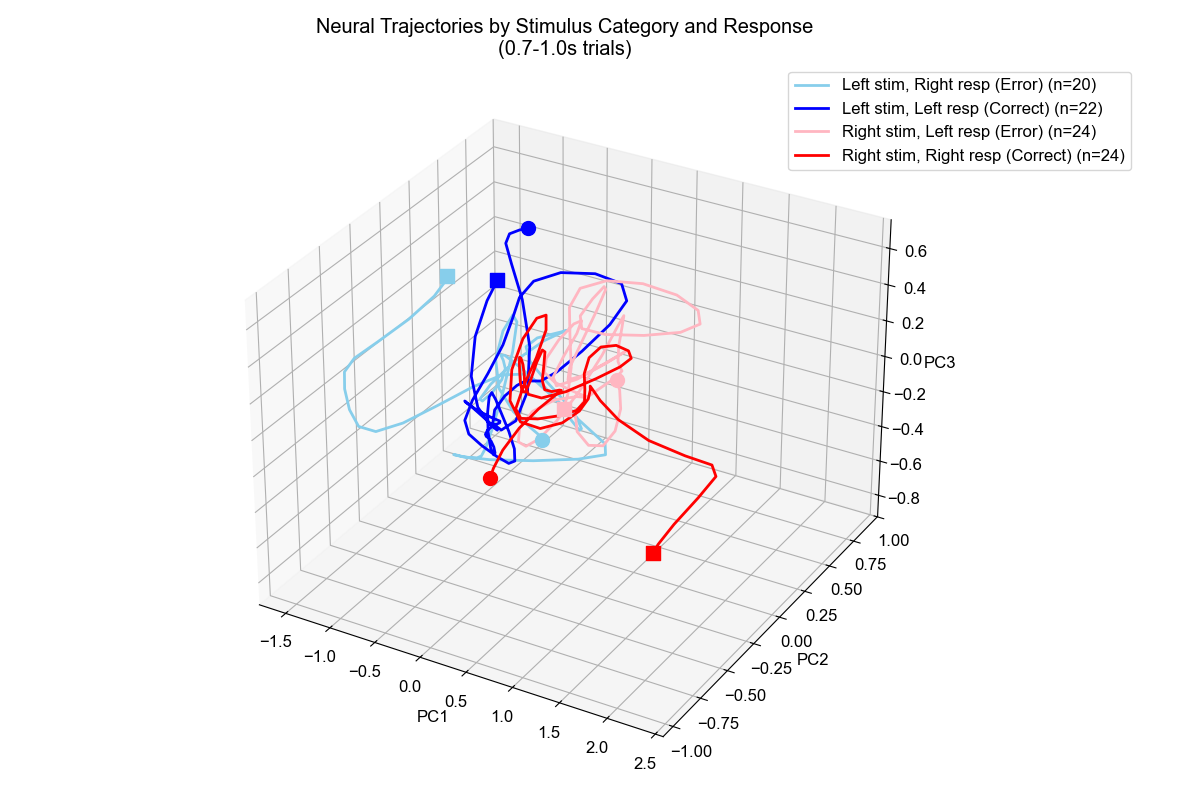

In [114]:
def get_trial_duration(stim_ts):
    return stim_ts[-1] - stim_ts[0]

trial_durations = balanced_trials.stim_ts.apply(get_trial_duration)

# Get trial statistics
stats_text = "Original trial statistics:\n"
stats_text += f"Total trials: {len(trial_durations)}\n"
stats_text += f"Duration range: {trial_durations.min():.3f}s to {trial_durations.max():.3f}s\n"
stats_text += f"Mean duration: {trial_durations.mean():.3f}s ± {trial_durations.std():.3f}s\n\n"

# Filter trials to only include those between 0.9 and 1 second
duration_mask = (trial_durations >= 0.7) & (trial_durations <= 1.0)
filtered_trials = balanced_trials[duration_mask]
filtered_decoder_matrix = decoder_matrix.sel(trial=filtered_trials.index)

# Add filtered trial statistics
stats_text += f"Filtered trial statistics:\n"
stats_text += f"Trials between 0.7-1.0s: {len(filtered_trials)} ({len(filtered_trials)/len(trial_durations)*100:.1f}%)\n"

# Define fixed analysis window
analysis_window = 0.7  # Analyze first 700ms of each trial
time_mask = filtered_decoder_matrix.time <= analysis_window
X_full = filtered_decoder_matrix.sel(time=time_mask).values

# Scale and PCA as before
scaler_full = StandardScaler()
X_full_reshaped = X_full.reshape(-1, X_full.shape[-1])
X_full_scaled = scaler_full.fit_transform(X_full_reshaped)
X_full_scaled = X_full_scaled.reshape(X_full.shape)

pca_3d = PCA(n_components=3)
X_full_3d = np.zeros((X_full_scaled.shape[0], X_full_scaled.shape[1], 3))
for t in range(X_full_scaled.shape[1]):
    X_full_3d[:,t,:] = pca_3d.fit_transform(X_full_scaled[:,t,:])

# Create figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors and markers for each condition
conditions = {
    ('left', 0): {'color': '#87CEEB', 'marker': 's', 'label': 'Left stim, Right resp (Error)'},
    ('left', 1): {'color': '#0000FF', 'marker': 's', 'label': 'Left stim, Left resp (Correct)'},
    ('right', 0): {'color': '#FFB6C1', 'marker': 's', 'label': 'Right stim, Left resp (Error)'},
    ('right', 1): {'color': '#FF0000', 'marker': 's', 'label': 'Right stim, Right resp (Correct)'}
}

# Apply smoothing using a Gaussian filter
sigma = 2

# Plot trajectories for each condition
for category in ['left', 'right']:
    for response in [0, 1]:
        # Get trials for this condition
        condition_mask = (filtered_decoder_matrix.category == category) & \
                        (filtered_decoder_matrix.response_side == response)
        
        # Skip if no trials in this condition
        if not condition_mask.any():
            continue
            
        n_trials = int(condition_mask.sum())
        print(f"{category} stim, response {response}: {n_trials} trials")
        
        # Calculate mean trajectory
        mean_trajectory = X_full_3d[condition_mask,:,:].mean(axis=0)
        
        # Smooth each dimension
        smoothed_trajectory = np.zeros_like(mean_trajectory)
        for dim in range(3):
            smoothed_trajectory[:,dim] = gaussian_filter1d(mean_trajectory[:,dim], sigma)
        
        # Get condition styling
        style = conditions[(category, response)]
        
        # Plot trajectory with trial count in label
        ax.plot(smoothed_trajectory[:,0], smoothed_trajectory[:,1], smoothed_trajectory[:,2],
                color=style['color'], label=f"{style['label']} (n={n_trials})",
                linewidth=2)
        
        # Plot start and end points
        ax.scatter(smoothed_trajectory[0,0], smoothed_trajectory[0,1], smoothed_trajectory[0,2],
                  color=style['color'], marker='o', s=100)
        ax.scatter(smoothed_trajectory[-1,0], smoothed_trajectory[-1,1], smoothed_trajectory[-1,2],
                  color=style['color'], marker=style['marker'], s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Neural Trajectories by Stimulus Category and Response\n(0.7-1.0s trials)')
ax.legend(bbox_to_anchor=(0.8, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('/Users/gabriel/lib/oqe-figures/decoding/PCA_trajectories_stim_x_response.svg', 
            format='svg', dpi=300, bbox_inches='tight')

Real label results:
Linear SVM accuracy: 0.618 ± 0.038
RBF SVM accuracy: 0.669 ± 0.052

Shuffled label results:
Linear SVM shuffle accuracy: 0.494 ± 0.074
RBF SVM shuffle accuracy: 0.447 ± 0.054


/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_51670/2097991486.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 2, figsize=(10, 10))


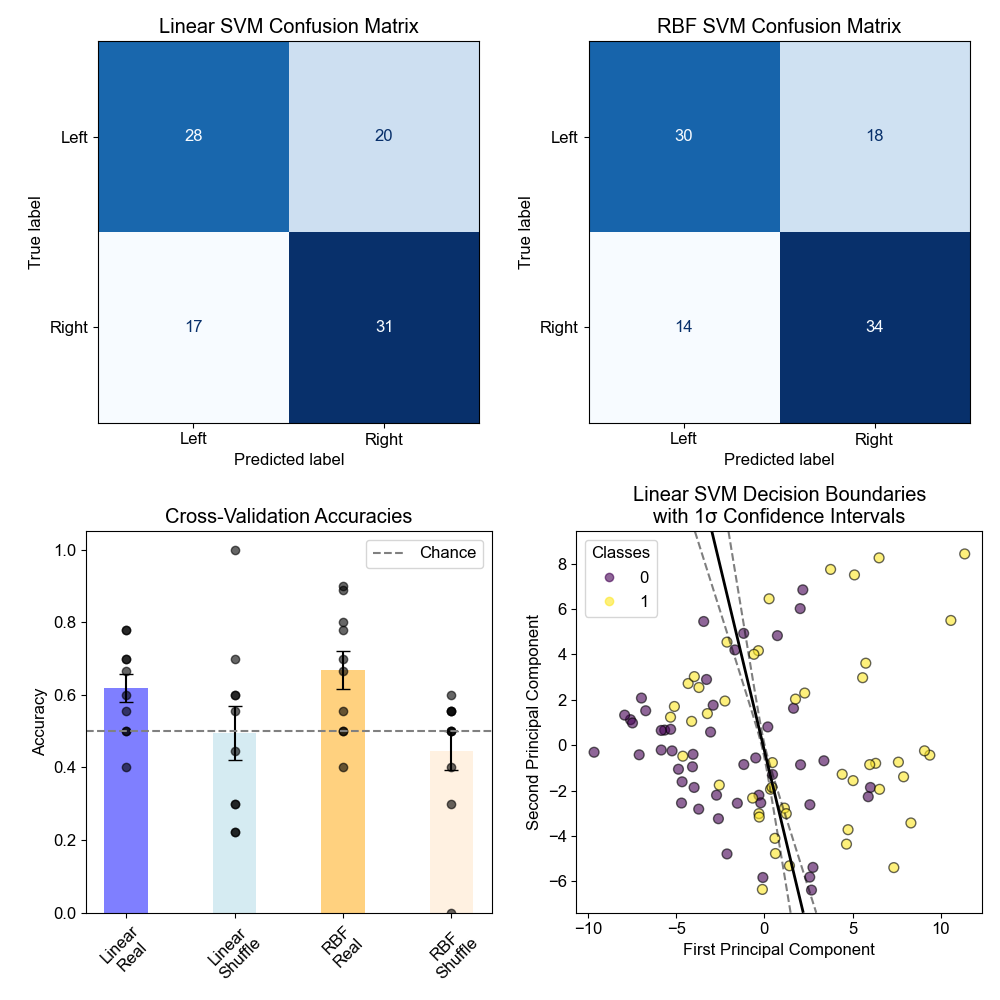

In [56]:
# Get neural activity during stimulus window
stim_window = decoder_matrix.sel(time=slice(0, 1))

# Average activity across time bins to get one value per unit per trial
X = stim_window.mean(dim='time').values

# Get trial categories (left vs right)
y = (decoder_matrix.category == 'right').values.astype(int)

# Initialize arrays to store results
linear_accuracies = []
rbf_accuracies = []
linear_predictions = []
rbf_predictions = []
true_labels = []

# Initialize arrays for shuffle controls
linear_shuffle_accuracies = []
rbf_shuffle_accuracies = []

# Create stratified k-fold cross validation splits
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# For each fold
for train_idx, test_idx in skf.split(X, y):
    # Split data into train and test sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Create shuffled labels for training
    y_train_shuffled = np.random.RandomState(42).permutation(y_train)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Linear SVM - real labels
    linear_svm = LinearSVC(penalty='l2', random_state=42, dual='auto')
    linear_svm.fit(X_train_scaled, y_train)
    
    # Train RBF SVM - real labels
    rbf_svm = SVC(kernel='rbf', random_state=42)
    rbf_svm.fit(X_train_scaled, y_train)
    
    # Train Linear SVM - shuffled labels
    linear_svm_shuffled = LinearSVC(penalty='l2', random_state=42, dual='auto')
    linear_svm_shuffled.fit(X_train_scaled, y_train_shuffled)
    
    # Train RBF SVM - shuffled labels
    rbf_svm_shuffled = SVC(kernel='rbf', random_state=42)
    rbf_svm_shuffled.fit(X_train_scaled, y_train_shuffled)
    
    # Make predictions - real labels
    linear_pred = linear_svm.predict(X_test_scaled)
    rbf_pred = rbf_svm.predict(X_test_scaled)
    
    # Make predictions - shuffled labels
    linear_pred_shuffled = linear_svm_shuffled.predict(X_test_scaled)
    rbf_pred_shuffled = rbf_svm_shuffled.predict(X_test_scaled)
    
    # Store results - real labels
    linear_accuracies.append(accuracy_score(y_test, linear_pred))
    rbf_accuracies.append(accuracy_score(y_test, rbf_pred))
    linear_predictions.extend(linear_pred)
    rbf_predictions.extend(rbf_pred)
    true_labels.extend(y_test)
    
    # Store results - shuffled labels
    linear_shuffle_accuracies.append(accuracy_score(y_test, linear_pred_shuffled))
    rbf_shuffle_accuracies.append(accuracy_score(y_test, rbf_pred_shuffled))

# Print accuracies
print("Real label results:")
print(f"Linear SVM accuracy: {np.mean(linear_accuracies):.3f} ± {np.std(linear_accuracies)/np.sqrt(len(linear_accuracies)):.3f}")
print(f"RBF SVM accuracy: {np.mean(rbf_accuracies):.3f} ± {np.std(rbf_accuracies)/np.sqrt(len(rbf_accuracies)):.3f}")
print("\nShuffled label results:")
print(f"Linear SVM shuffle accuracy: {np.mean(linear_shuffle_accuracies):.3f} ± {np.std(linear_shuffle_accuracies)/np.sqrt(len(linear_shuffle_accuracies)):.3f}")
print(f"RBF SVM shuffle accuracy: {np.mean(rbf_shuffle_accuracies):.3f} ± {np.std(rbf_shuffle_accuracies)/np.sqrt(len(rbf_shuffle_accuracies)):.3f}")

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# 1. Confusion Matrices
cm_linear = confusion_matrix(true_labels, linear_predictions)
cm_rbf = confusion_matrix(true_labels, rbf_predictions)

ConfusionMatrixDisplay(
    confusion_matrix=cm_linear,
    display_labels=['Left', 'Right']
).plot(ax=axes[0,0], cmap='Blues', colorbar=False)
axes[0,0].set_title('Linear SVM Confusion Matrix')

ConfusionMatrixDisplay(
    confusion_matrix=cm_rbf,
    display_labels=['Left', 'Right']
).plot(ax=axes[0,1], cmap='Blues', colorbar=False)
axes[0,1].set_title('RBF SVM Confusion Matrix')

# 2. Bar plot of accuracies with individual points and shuffle distributions
bar_positions = [0, 1, 2, 3]
bar_width = 0.4
means = [np.mean(linear_accuracies), np.mean(linear_shuffle_accuracies),
         np.mean(rbf_accuracies), np.mean(rbf_shuffle_accuracies)]
sems = [np.std(linear_accuracies)/np.sqrt(len(linear_accuracies)),
        np.std(linear_shuffle_accuracies)/np.sqrt(len(linear_shuffle_accuracies)),
        np.std(rbf_accuracies)/np.sqrt(len(rbf_accuracies)), 
        np.std(rbf_shuffle_accuracies)/np.sqrt(len(rbf_shuffle_accuracies))]

# Plot bars
bars = axes[1,0].bar(bar_positions, means, bar_width,
                    yerr=sems, capsize=5, alpha=0.5,
                    color=['blue', 'lightblue', 'orange', 'bisque'])

# Plot individual points
for i, acc in enumerate([linear_accuracies, linear_shuffle_accuracies,
                        rbf_accuracies, rbf_shuffle_accuracies]):
    axes[1,0].scatter([i] * len(acc), acc,
                     color='black', alpha=0.6,
                     zorder=2)

# Customize the plot
axes[1,0].set_xticks(bar_positions)
axes[1,0].set_xticklabels(['Linear\nReal', 'Linear\nShuffle',
                          'RBF\nReal', 'RBF\nShuffle'], rotation=45)
axes[1,0].axhline(y=0.5, color='gray', linestyle='--', label='Chance')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_title('Cross-Validation Accuracies')
axes[1,0].legend()

# 3. Decision boundaries across folds
# Scale and PCA transform full dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Create mesh grid for decision boundaries
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                    np.arange(y_min, y_max, 0.02))

# Initialize arrays to store decision function values and weights for each fold
linear_decisions = []
rbf_decisions = []
linear_weights = []

# For each fold
for train_idx, test_idx in skf.split(X_2d, y):
    X_train, y_train = X_2d[train_idx], y[train_idx]
    
    # Train SVMs
    linear_svm = LinearSVC(penalty='l2', random_state=42, dual='auto')
    rbf_svm = SVC(kernel='rbf', random_state=42)
    
    linear_svm.fit(X_train, y_train)
    rbf_svm.fit(X_train, y_train)
    
    # Store weights from linear SVM
    linear_weights.append(np.abs(linear_svm.coef_[0]))
    
    # Get decision function values
    linear_decision = linear_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    rbf_decision = rbf_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    
    linear_decisions.append(linear_decision.reshape(xx.shape))
    rbf_decisions.append(rbf_decision.reshape(xx.shape))

# Convert to arrays
linear_decisions = np.array(linear_decisions)
rbf_decisions = np.array(rbf_decisions)
linear_weights = np.array(linear_weights)

# Calculate mean and std of decision boundaries and weights
linear_mean = linear_decisions.mean(axis=0)
linear_std = linear_decisions.std(axis=0)
rbf_mean = rbf_decisions.mean(axis=0)
rbf_std = rbf_decisions.std(axis=0)
mean_weights = linear_weights.mean(axis=0)

# Plot decision boundaries with confidence intervals
for kernel, mean_decision, std_decision in [('Linear', linear_mean, linear_std), 
                                          ('RBF', rbf_mean, rbf_std)]:
    ax = axes[1,1] if kernel == 'Linear' else None
    if ax is None:
        continue
        
    # Plot mean decision boundary
    ax.contour(xx, yy, mean_decision, levels=[0], colors='k', linestyles='-', linewidths=2)
    
    # Plot confidence intervals
    ax.contour(xx, yy, mean_decision + std_decision, levels=[0], colors='k', linestyles='--', alpha=0.5)
    ax.contour(xx, yy, mean_decision - std_decision, levels=[0], colors='k', linestyles='--', alpha=0.5)
    
    # Plot data points with uniform size
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, s=50, alpha=0.6, edgecolors='k')
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title(f'{kernel} SVM Decision Boundaries\nwith 1σ Confidence Intervals')
    ax.legend(*scatter.legend_elements(), title="Classes")

plt.tight_layout()
plt.show()

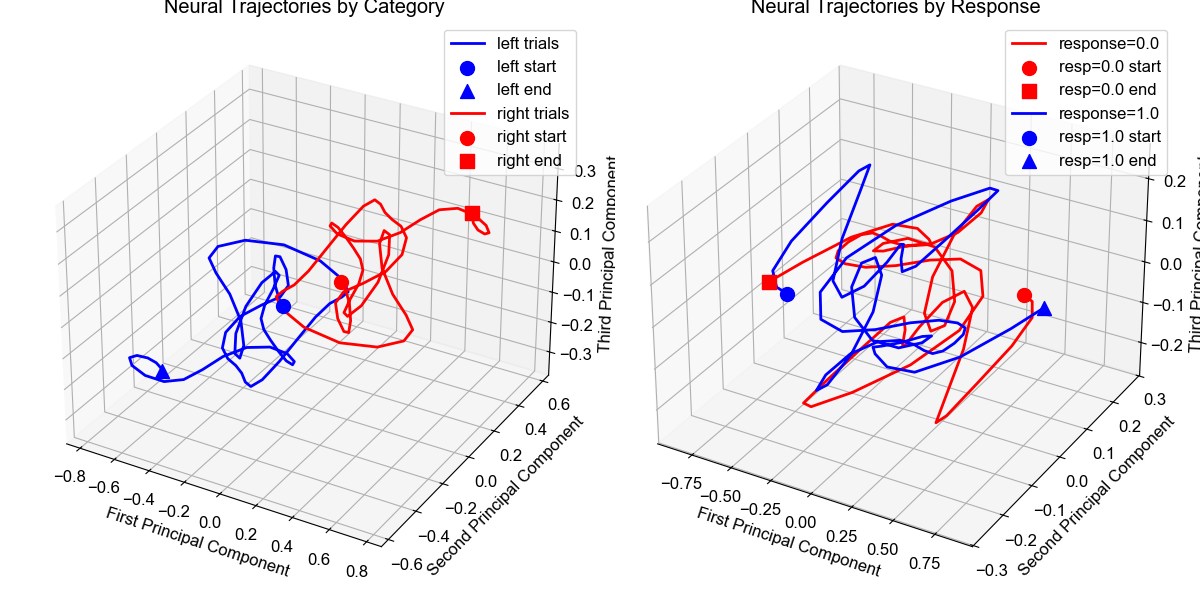

In [38]:
# Get full trial-by-time-by-unit data
X_full = decoder_matrix.values

# Remove timepoints with any NaN values
valid_timepoints = ~np.any(np.isnan(X_full), axis=(0,2))
X_full = X_full[:,valid_timepoints,:]

# Scale the full dataset with a new scaler
scaler_full = StandardScaler()
X_full_reshaped = X_full.reshape(-1, X_full.shape[-1])  # Reshape to 2D for scaling
X_full_scaled = scaler_full.fit_transform(X_full_reshaped)
X_full_scaled = X_full_scaled.reshape(X_full.shape)  # Reshape back to 3D

# Project each timepoint through PCA with 3 components
pca_3d = PCA(n_components=3)
X_full_3d = np.zeros((X_full_scaled.shape[0], X_full_scaled.shape[1], 3))
for t in range(X_full_scaled.shape[1]):
    X_full_3d[:,t,:] = pca_3d.fit_transform(X_full_scaled[:,t,:])

# Create figure with two subplots
fig = plt.figure(figsize=(12,6))

# First subplot for categories
ax1 = fig.add_subplot(121, projection='3d')

# Plot average trajectories for each category
categories = decoder_matrix.category.values
unique_categories = np.unique(categories)
colors = {'left': 'blue', 'right': 'red'}
markers = {'left': '^', 'right': 's'}

# Apply smoothing using a Gaussian filter
from scipy.ndimage import gaussian_filter1d
sigma = 2

for cat in unique_categories:
    cat_mask = categories == cat
    mean_trajectory = X_full_3d[cat_mask,:,:].mean(axis=0)
    
    # Smooth each dimension separately
    smoothed_trajectory = np.zeros_like(mean_trajectory)
    for dim in range(3):
        smoothed_trajectory[:,dim] = gaussian_filter1d(mean_trajectory[:,dim], sigma)
    
    ax1.plot(smoothed_trajectory[:,0], smoothed_trajectory[:,1], smoothed_trajectory[:,2],
            color=colors[cat], label=f'{cat} trials',
            linewidth=2)
    
    # Plot start point (circle) and end point (category-specific marker)
    ax1.scatter(smoothed_trajectory[0,0], smoothed_trajectory[0,1], smoothed_trajectory[0,2],
              color=colors[cat], marker='o', s=100, label=f'{cat} start')
    ax1.scatter(smoothed_trajectory[-1,0], smoothed_trajectory[-1,1], smoothed_trajectory[-1,2],
              color=colors[cat], marker=markers[cat], s=100, label=f'{cat} end')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component') 
ax1.set_zlabel('Third Principal Component')
ax1.set_title('Neural Trajectories by Category')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Second subplot for response values
ax2 = fig.add_subplot(122, projection='3d')

# Plot average trajectories for each response value
response_values = decoder_matrix.response_side.values
unique_responses = np.unique(response_values)
# Map 0 to 'right' and 1 to 'left' to use same colors/markers
response_mapping = {1: 'left', 0: 'right'}

for resp in unique_responses:
    resp_mask = response_values == resp
    mean_trajectory = X_full_3d[resp_mask,:,:].mean(axis=0)
    
    # Smooth each dimension separately
    smoothed_trajectory = np.zeros_like(mean_trajectory)
    for dim in range(3):
        smoothed_trajectory[:,dim] = gaussian_filter1d(mean_trajectory[:,dim], sigma)
    
    mapped_resp = response_mapping[resp]
    ax2.plot(smoothed_trajectory[:,0], smoothed_trajectory[:,1], smoothed_trajectory[:,2],
            color=colors[mapped_resp], label=f'response={resp}',
            linewidth=2)
    
    # Plot start point (circle) and end point (response-specific marker)
    ax2.scatter(smoothed_trajectory[0,0], smoothed_trajectory[0,1], smoothed_trajectory[0,2],
              color=colors[mapped_resp], marker='o', s=100, label=f'resp={resp} start')
    ax2.scatter(smoothed_trajectory[-1,0], smoothed_trajectory[-1,1], smoothed_trajectory[-1,2],
              color=colors[mapped_resp], marker=markers[mapped_resp], s=100, label=f'resp={resp} end')

ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component') 
ax2.set_zlabel('Third Principal Component')
ax2.set_title('Neural Trajectories by Response')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
